<a href="https://colab.research.google.com/github/vchandraiitk/datascience/blob/main/Copy_of_Vikas_M6_NB_MiniProject_2_Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Face Mask Detection using Convolutional Neural Networks

## Learning Objectives

At the end of the miniproject, you will be able to :

* load and extract features of images using ImageDataGenerator

* build the convolutional neural networks

* use the pre-trained models using keras applications

## Introduction

This project uses a Deep Neural Network, more specifically a Convolutional Neural Network, to differentiate between images of people, with masks, without masks and incorrectly placed masks. Manually built and pretrained networks will be used to perform this classification task.

**Face-Mask-Detection-Using-CNN**

* Outbreak of the Coronavirus pandemic has created various changes in the lifestyle of everyone around the world.
* Among these changes, wearing a mask has been very vital to every individual.
* Detection of people who are not wearing masks is a challenge due to the large populations.
* This face mask detection project can be used in schools, hospitals, banks, airports etc as a digitalized scanning tool.
  - The technique of detecting people’s faces and segregating them into three classes namely the people with masks and people without masks and partial masks is done with the help of image processing and deep learning.
* With the help of this project, a person who is monitoring the face mask status for a particular firm can be seated in a remote area and still monitor efficiently and give instructions accordingly.

![img](https://cdn.iisc.talentsprint.com/CDS/MiniProjects/dataset-images-with-mask.jpg)

## Dataset

The data for this mini-project is collected from various sources including the masked images from internet and general frontal face images considered as without mask. This dataset consists of 5029 train images and 1259 test images with 3 classes `with_mask`, `without_mask` and `partial_mask`

Many people do not correctly wear their masks due to bad practices, bad behaviors or vulnerability of individuals (e.g., children, old people). For these reasons, several mask wearing campaigns intend to sensitize people about this problem and good practices. In this sense, this work proposes three types of masked face detection dataset:

- Without Mask/ With Mask/ Partial Mask

Note that this dataset contains some annotated (artificially generated) masks to augment the 'masked' data category.

## Problem Statement

To build and implement a Convolutional Neural Network model to classify between masked/unmasked/partially masked faces.

## Grading = 10 Points

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/ISC/MiniProject/M6-Mp2')

In [ ]:
print(os.getcwd())

/content/drive/MyDrive/ISC/MiniProject/M6-Mp2


In [ ]:
os.environ['HOME'] = '/content/drive/MyDrive/ISC/MiniProject/M6-Mp2'

In [ ]:
#@title Download the data
#!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/MP2_FaceMask_Dataset.zip
#!unzip -qq MP2_FaceMask_Dataset.zip
#print("Data Downloaded Successfuly!!")

### Import Required packages

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import PIL
from matplotlib import pyplot as plt
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow import keras
import glob, os
from PIL import Image

## Data Loading and preprocessing (2 points)

### Analyze the shape of images and distribution of classes

In [ ]:
# YOUR CODE HERE
#Image.open("/content/MP2_FaceMask_Dataset/train/with_mask/0-with-mask.jpg").size
TRAINING_DIR = "/content/drive/MyDrive/ISC/MiniProject/M6-Mp2/MP2_FaceMask_Dataset/train/"
VALIDATION_DIR = "/content/drive/MyDrive/ISC/MiniProject/M6-Mp2/MP2_FaceMask_Dataset/test/"
def get_shapes_and_classes(path):
  shapes = []
  classes = []
  for class_folder in os.listdir(path):
    #print(class_folder)
    class_path = os.path.join(path, class_folder)
    if os.path.isdir(class_path):
      for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        image = Image.open(image_path)
        shapes.append(image.size)
        classes.append(class_folder)
  return pd.DataFrame({'shape': shapes, 'class': classes})

In [ ]:
train_df = get_shapes_and_classes(TRAINING_DIR)
val_df = get_shapes_and_classes(VALIDATION_DIR)

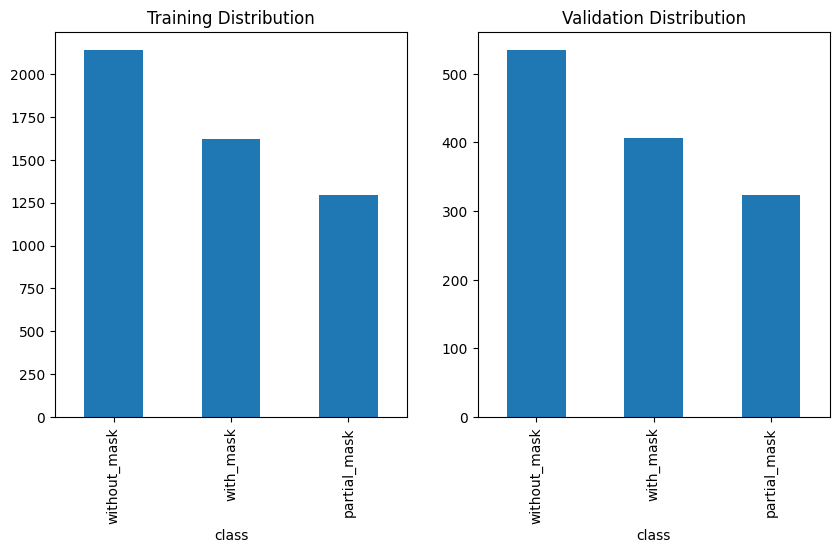

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Training Distribution")
train_df['class'].value_counts().plot(kind='bar')
plt.subplot(1, 2, 2)
plt.title("Validation Distribution")
val_df['class'].value_counts().plot(kind='bar')
plt.show()

### Load the images using ImageDataGenerator

There are two main steps involved in creating the generator.
1. Instantiate ImageDataGenerator with required arguments to create an object
2. Use the `flow_from_directory` command depending on how your data is stored on disk. This is the command that will allow you to generate and get access to batches of data on the fly.

Hint: [link](https://keras.io/api/preprocessing/image/)

In [ ]:
#TRAINING_DIR = "/content/MP2_FaceMask_Dataset/train/"
#VALIDATION_DIR = "/content/MP2_FaceMask_Dataset/test/"

In [ ]:
# YOUR CODE HERE
# Model Parameters
batch_size = 256

# Instantiate ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,              # Path to the training data directory
    target_size=(224, 224),   # Resize images to 224x224
    batch_size=32,             # Generate batches of 32 images
    class_mode='categorical'   # Use 'categorical' for multi-class classification
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 5029 images belonging to 3 classes.
Found 1259 images belonging to 3 classes.


### Visualize the sample images of each class using data generator

Hint: plt.subplot

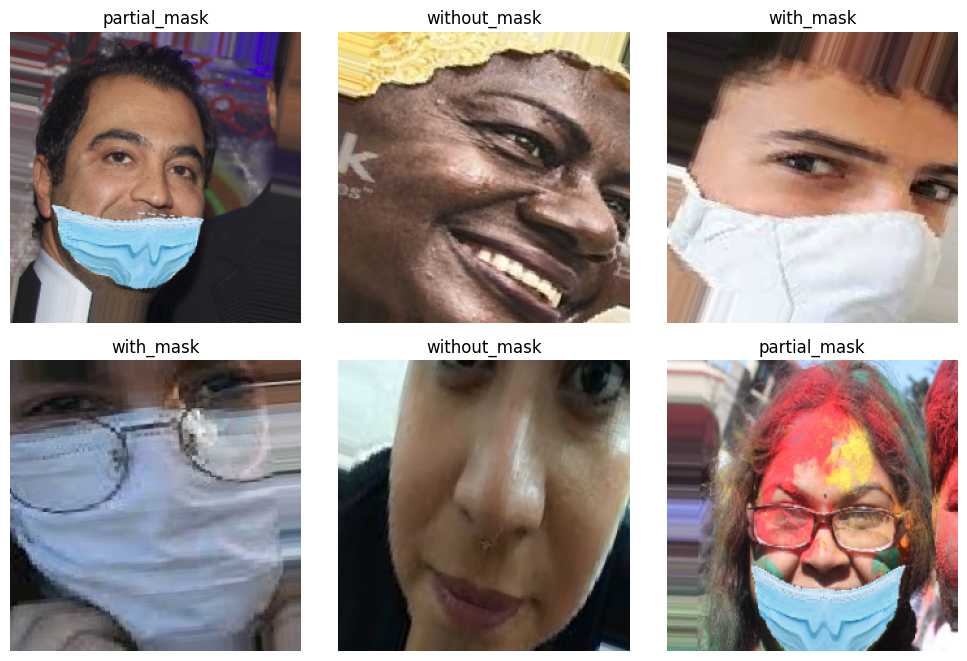

In [ ]:
# YOUR CODE HERE
# Get a batch of images and labels from the training generator
images, labels = next(train_generator)
filenames = train_generator.filenames[train_generator.batch_index - 1: train_generator.batch_index - 1 + train_generator.batch_size]

# Define class names for the labels (assuming you have 3 classes: 'with_mask', 'without_mask', 'partial_mask')
class_names = ['partial_mask','with_mask', 'without_mask']

# Display a grid of images with their corresponding labels
plt.figure(figsize=(10, 10))
images_map = {}
images_map['partial_mask'] = 0
images_map['with_mask'] = 0
images_map['without_mask'] = 0


counter=1
for i in range(100):  # Display the first 6 images and 2 from each
    if images_map['with_mask'] == 2 and images_map['without_mask'] == 2 and images_map['partial_mask'] == 2:
      break
    if images_map[class_names[np.argmax(labels[i])]] < 2:
        plt.subplot(3, 3, counter)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])  # Get the class with the highest probability
        plt.axis('off')
        images_map[class_names[np.argmax(labels[i])]] += 1
        counter += 1
        # print(class_names[np.argmax(labels[i])])
        # print(np.argmax(labels[i]))
        # print(filenames[i])
plt.tight_layout()
plt.show()

## Build the CNN model using Keras (4 points)



**Convolutional Neural Network:** A neural network in which at least one layer is a convolutional layer. A typical convolutional neural network consists of some combination of the following layers:

* convolutional layers
* pooling layers
* dense layers


**Conv2D**

Passing an image with input shape of 3-D and to calculate the output:

 $O = \frac{n - f + 2p}{s} + 1$

 where

 $n$ = image dimension

 $f$ = filter size

 $p$ = padding

 $s$ = stride

**MaxPool**

The resulting output, when using the "valid" padding option, has a spatial shape (number of rows or columns) of:

O = `math.floor`$(\frac{input shape - pool size)}{ strides}) + 1$ (when input shape >= pool size)

The resulting output shape when using the "same" padding option is:

O = `math.floor`$(\frac{input shape - 1}{strides}) + 1$

by default, stride = None, so stride is same as pool size

Task-flow
* Initialize the network of convolution, maxpooling and dense layers
* Define the optimizer and loss functions
* Fit the model and evaluate the model

In [ ]:
# YOUR CODE HERE
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#optimizer and loss functions
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator)

# Evaluate on the test set
loss, accuracy = model.evaluate(validation_generator)
print('Test accuracy:', accuracy)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


158/158 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.6940 - loss: 1.2024 - val_accuracy: 0.9404 - val_loss: 0.1874
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 80s 484ms/step - accuracy: 0.9255 - loss: 0.2265 - val_accuracy: 0.9508 - val_loss: 0.1816
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 79s 482ms/step - accuracy: 0.9506 - loss: 0.1728 - val_accuracy: 0.9627 - val_loss: 0.1244
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 80s 485ms/step - accuracy: 0.9462 - loss: 0.1681 - val_accuracy: 0.9651 - val_loss: 0.1293
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 80s 484ms/step - accuracy: 0.9633 - loss: 0.1305 - val_accuracy: 0.9595 - val_loss: 0.1208
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 80s 486ms/step - accuracy: 0.9661 - loss: 0.1047 - val_accuracy: 0.9778 - val_loss: 0.0926
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 80s 484ms/step - accuracy: 0.9624 - loss: 0.1065 - val_accuracy: 0.9833 - val_loss: 0.0809
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 80s 483ms/step - accuracy: 0.9656 - loss: 0.1075 - val_a

## Transfer learning (4 points)

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

For eg. Using VGG16, we remove the last layer which takes a probability for each of the 1000 classes in the ImageNet and replaces it with a layer that takes 3 probabilities in our case.

### Use the pre-trained models ([VGG16](https://cdn.exec.talentsprint.com/static/cds/content/M6_SNB_MiniProject_2_VGG16.pdf) or [ResNet50](https://cdn.exec.talentsprint.com/static/cds/content/M6_SNB_MiniProject_2_ResNet50.pdf))

* Load the pre-trained model
* Fit and evaluate the data

Hint: [How to use pre-trained model](https://cdn.exec.talentsprint.com/static/cds/content/A_Simple_Guide_to_Using_Keras_Pretrained_Models_by_Shiva_Verma_Towards_Data_Science_3.pdf)

#### Expected accuracy: More than 90%

Task-flow
* Initialize the network with the weights of Imagenet
* Fine tune the network by modifying fully connected layers.
* Re-train the model with our problem data

#### VGG16

In [ ]:
# Create a custom image classification model using VGG16 as the base with added Dense layers for fine-tuning in TensorFlow Keras.
# YOUR CODE HERE
# Parameters
IMG_SIZE = (224, 224)  # Image input size for VGG16
NUM_CLASSES = 3        # Number of classes (update according to your dataset)
BATCH_SIZE = 32
LEARNING_RATE = 0.0001  # Learning rate for the optimizer
EPOCHS = 20

# Load the VGG16 model with pre-trained weights, excluding the top layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze the base model layers to retain pre-trained weights
for layer in vgg16_base.layers:
    layer.trainable = False

# Add custom layers on top of the VGG16 base
x = Flatten()(vgg16_base.output)  # Flatten the feature maps
x = Dense(256, activation='relu')(x)  # Fully connected layer with 256 units
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(128, activation='relu')(x)  # Fully connected layer with 128 units
x = Dropout(0.3)(x)  # Dropout for regularization
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)  # Output layer for classification

# Create the complete model
model = Model(inputs=vgg16_base.input, outputs=output_layer)

In [ ]:
# Compile the VGG16-based model with the Adam optimizer (learning rate 0.00001), categorical cross-entropy loss, and accuracy as the metric
# YOUR CODE HERE
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,170,755 (80.76 MB)

 Trainable params: 6,456,067 (24.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Train the VGG16-based model for 5 epochs using the training and validation data generators, with specified class weights {0:1.0, 1:0.8, 2:1.2}
# YOUR CODE HERE
history_vgg = model.fit(train_generator,
                            epochs=5,
                            validation_data=validation_generator,
                            class_weight={0: 1.0, 1: 0.8, 2: 1.2})

Epoch 1/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 103s 545ms/step - accuracy: 0.7225 - loss: 0.6197 - val_accuracy: 0.9619 - val_loss: 0.1068
Epoch 2/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 80s 486ms/step - accuracy: 0.9370 - loss: 0.1727 - val_accuracy: 0.9801 - val_loss: 0.0620
Epoch 3/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 83s 504ms/step - accuracy: 0.9553 - loss: 0.1247 - val_accuracy: 0.9809 - val_loss: 0.0544
Epoch 4/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 83s 505ms/step - accuracy: 0.9627 - loss: 0.1031 - val_accuracy: 0.9722 - val_loss: 0.0700
Epoch 5/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 81s 490ms/step - accuracy: 0.9676 - loss: 0.0893 - val_accuracy: 0.9809 - val_loss: 0.0493


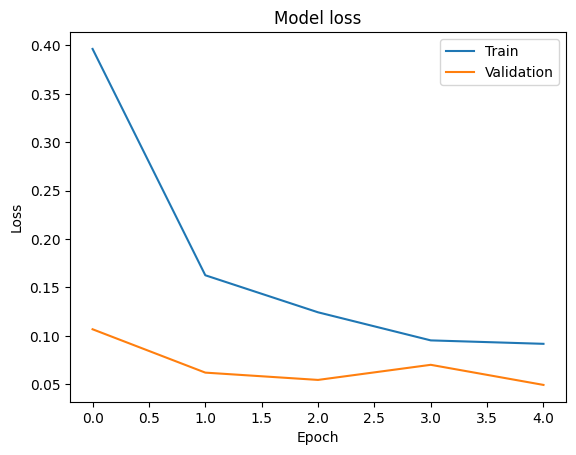

In [ ]:
# Plot the training and validation loss over epochs
# YOUR CODE HERE
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Save the model in HDF5 format
# YOUR CODE HERE
# Save the model
model.save('face_mask_detector_vgg16.h5')

In [ ]:
# Save the model in keras format
# YOUR CODE HERE
# Save the model
model.save('face_mask_detector_vgg16.keras')

#### ResNet50

In [ ]:
# Build and compile a sequential model using ResNet50 as the base, with added Dense layers for classification, and display the model summary
# YOUR CODE HERE
from tensorflow.keras.layers import GlobalAveragePooling2D # Import GlobalAveragePooling2D from tensorflow.keras.layers
# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a Sequential model
model_resnet = Sequential()

# Add the ResNet50 base model
model_resnet.add(base_model)

# Add new layers for classification
model_resnet.add(GlobalAveragePooling2D())
model_resnet.add(Dense(128, activation='relu'))  # You can adjust the number of units and activation
model_resnet.add(Dense(3, activation='softmax'))  # 3 classes: with_mask, without_mask, partial_mask

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_resnet.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Display the model summary
model_resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Train the ResNet50-based model for 5 epochs using the training and validation data generators
# YOUR CODE HERE
# Train the model
history_resnet = model_resnet.fit(train_generator,
                                  epochs=5,
                                  validation_data=validation_generator)

Epoch 1/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 105s 562ms/step - accuracy: 0.4320 - loss: 1.0390 - val_accuracy: 0.5711 - val_loss: 0.8544
Epoch 2/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 81s 490ms/step - accuracy: 0.5755 - loss: 0.8993 - val_accuracy: 0.6322 - val_loss: 0.7677
Epoch 3/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 80s 490ms/step - accuracy: 0.6170 - loss: 0.8224 - val_accuracy: 0.6624 - val_loss: 0.7367
Epoch 4/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 81s 490ms/step - accuracy: 0.6429 - loss: 0.7758 - val_accuracy: 0.6950 - val_loss: 0.6349
Epoch 5/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 81s 493ms/step - accuracy: 0.6776 - loss: 0.7290 - val_accuracy: 0.7252 - val_loss: 0.5959


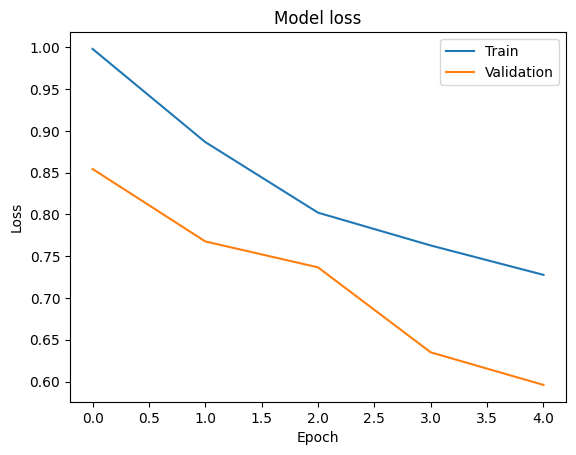

In [ ]:
# Plot the training and validation loss over epochs
# YOUR CODE HERE
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Capture the live image using the below code cell and predict

In [ ]:
#@title Capture the photo
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

After executing above cell and capturing the photo, load the captured photo and predict with model.

**Note:**
* Convert the image to numpy array and resize to the shape which the model accepts.
* Extend the dimension (to 4-D shape) of an image, as the model is trained on a batch of inputs.

In [ ]:
MODEL = model
features = PIL.Image.open("photo.jpg")
features = features.resize((224, 224))
plt.imshow(features);
# YOUR CODE HERE to predict the image
# Preprocess for the model
image_array = np.array(features)  # Convert PIL Image to NumPy array
image_array = np.expand_dims(image_array, axis=0)  # Expand dimensions for batch

# Make prediction
prediction = MODEL.predict(image_array)

# Interpret the prediction
# Assuming 3 classes: with_mask, without_mask, partial_mask
#class_names = ['with_mask', 'without_mask', 'partial_mask']
predicted_class_index = np.argmax(prediction)
predicted_class = class_names[predicted_class_index]

print(f"Predicted class: {predicted_class}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ISC/MiniProject/M6-Mp2/photo.jpg'

### Report Analysis

- Compare the accuracies for the Pre-trained vs CNN models
- Which model detects the mask/no mask/ partial mask more accurately with the live pictures?
- What process was followed to tune the hyperparameters?
- Discuss the confusion matrix in terms of the misclassifications

### Kaggle predictions

In [ ]:
# Download the saved VGG model
# Your code here
from google.colab import files

files.download('face_mask_detector_vgg16.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### Instructions for preparing Kaggle competition predictions

Important: Refer the [Kaggle Team Creation Instructions Doc](https://drive.google.com/file/d/1V0GlyApGPvksSEPhlfkJIQndt4zIBOdY/view?usp=drive_link)

* Load the image paths from Kaggle testset using `glob`
* Read the Images using `PIL.Image.open` and resize to required shape.
* Get the predictions using trained model and prepare a csv file
  - FC layer of DeepNet model gives output for each class, consider the maximum value among all classes as prediction using `np.argmax`.
* Predictions (csv) file should contain 2 columns as Sample_Submission.csv
  - First column is the img_path which is considered as index
  - Second column is prediction in decoded form (for eg. with_mask, partial_mask, without_mask).
  - Note that at the time of submission to Kaggle, predictions need to be sorted in ascending order i.e, same as sample submission file.

<font color='magenta'>If you are unable to download the data and sample submission from the Kaggle Competition site then please use the download cell below.</font>


In [ ]:
#@title Download test data and SampleSubmission file for Kaggle submission
#!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/FaceMask_Kaggle_test.zip
#!unzip -qq FaceMask_Kaggle_test.zip
#!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/Sample_Submission.csv
#print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


#### Create a dataframe with kaggle data

In [ ]:
# Create a DataFrame of image paths from the "FaceMask_Kaggle_test" directory, extract and sort by the numeric order in the filenames, and display the DataFrame
# YOUR CODE HERE
import pandas as pd
import os
import re

def create_image_path_dataframe(directory="FaceMask_Kaggle_test"):
    """
    Creates a DataFrame of image paths from a directory, sorted by numeric order in filenames.

    Args:
        directory (str): Path to the directory containing images.

    Returns:
        pandas.DataFrame: DataFrame with 'image_path' and 'image_number' columns.
    """

    image_paths = []
    for filename in os.listdir(directory):
        if filename.endswith(('jpg', 'jpeg', 'png', )):  # Adjust file extensions as needed
            image_paths.append(os.path.join(directory, filename))

    # Extract numeric part of filenames and sort
    df = pd.DataFrame({'image_path': image_paths})
    df['image_number'] = df['image_path'].str.extract(r'(\d+)').astype(int)  # Assumes numeric part in filename
    df = df.sort_values(by=['image_number']).reset_index(drop=True)

    return df

# Create and display the DataFrame
image_df = create_image_path_dataframe()
print(image_df)

                       image_path  image_number
0      FaceMask_Kaggle_test/1.jpg             1
1      FaceMask_Kaggle_test/2.jpg             2
2      FaceMask_Kaggle_test/3.jpg             3
3      FaceMask_Kaggle_test/4.jpg             4
4      FaceMask_Kaggle_test/5.jpg             5
..                            ...           ...
655  FaceMask_Kaggle_test/656.jpg           656
656  FaceMask_Kaggle_test/657.jpg           657
657  FaceMask_Kaggle_test/658.jpg           658
658  FaceMask_Kaggle_test/659.jpg           659
659  FaceMask_Kaggle_test/660.jpg           660

[660 rows x 2 columns]


In [ ]:
# Display rows 120 to 135 of the DataFrame
# YOUR CODE HERE
print(image_df.iloc[120:136])  # Use iloc for integer-based indexing

                       image_path  image_number
120  FaceMask_Kaggle_test/121.jpg           121
121  FaceMask_Kaggle_test/122.jpg           122
122  FaceMask_Kaggle_test/123.jpg           123
123  FaceMask_Kaggle_test/124.jpg           124
124  FaceMask_Kaggle_test/125.jpg           125
125  FaceMask_Kaggle_test/126.jpg           126
126  FaceMask_Kaggle_test/127.jpg           127
127  FaceMask_Kaggle_test/128.jpg           128
128  FaceMask_Kaggle_test/129.jpg           129
129  FaceMask_Kaggle_test/130jpeg           130
130  FaceMask_Kaggle_test/131.jpg           131
131  FaceMask_Kaggle_test/132.jpg           132
132  FaceMask_Kaggle_test/133.jpg           133
133  FaceMask_Kaggle_test/134.jpg           134
134  FaceMask_Kaggle_test/135.jpg           135
135  FaceMask_Kaggle_test/136jpeg           136


#### Extract features of kaggle data

In [ ]:
# Resize images from the img_path column in the DataFrame df to 224x224, append them to a list, and convert the list to a NumPy array
# YOUR CODE HERE
import numpy as np
from PIL import Image

def preprocess_images_from_dataframe(df, target_size=(224, 224)):
    """
    Resizes images from the 'img_path' column of a DataFrame,
    appends them to a list, and converts the list to a NumPy array.

    Args:
        df (pandas.DataFrame): DataFrame containing 'img_path' column.
        target_size (tuple): Desired size of the images (width, height).

    Returns:
        numpy.ndarray: NumPy array of resized images.
    """

    resized_images = []
    for image_path in df['image_path']:
        img = Image.open(image_path)

        # Convert to RGB if needed
        if img.mode != 'RGB':
            img = img.convert('RGB')

        img = img.resize(target_size)
        img_array = np.array(img)
        resized_images.append(img_array)

    return np.array(resized_images)

# Example usage:
resized_images_array = preprocess_images_from_dataframe(image_df)

print(resized_images_array.shape)  # Print the shape of the NumPy array

(660, 224, 224, 3)


#### Load the saved model and predict the kaggle features

In [ ]:
# Ensure consistent usage of TensorFlow's Keras
# YOUR CODE HERE

In [ ]:
# Generate predictions
# YOUR CODE HERE
# Generate predictions
predictions = model.predict(resized_images_array)

# Interpret predictions (example with 3 classes: with_mask, without_mask, partial_mask)
#class_names = ['with_mask', 'without_mask', 'partial_mask']  # Adjust if needed
predicted_classes = [class_names[np.argmax(prediction)] for prediction in predictions]

# Print or store the predictions as needed
for i, predicted_class in enumerate(predicted_classes):
    print(f"Image {i}: Predicted class - {predicted_class}")

# You can also add the predictions to your DataFrame:
image_df['predicted_class'] = predicted_classes
print(image_df)

21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 482ms/step
Image 0: Predicted class - partial_mask
Image 1: Predicted class - partial_mask
Image 2: Predicted class - partial_mask
Image 3: Predicted class - without_mask
Image 4: Predicted class - without_mask
Image 5: Predicted class - partial_mask
Image 6: Predicted class - partial_mask
Image 7: Predicted class - partial_mask
Image 8: Predicted class - partial_mask
Image 9: Predicted class - partial_mask
Image 10: Predicted class - without_mask
Image 11: Predicted class - without_mask
Image 12: Predicted class - partial_mask
Image 13: Predicted class - partial_mask
Image 14: Predicted class - without_mask
Image 15: Predicted class - partial_mask
Image 16: Predicted class - without_mask
Image 17: Predicted class - without_mask
Image 18: Predicted class - partial_mask
Image 19: Predicted class - partial_mask
Image 20: Predicted class - partial_mask
Image 21: Predicted class - partial_mask
Image 22: Predicted class - without_mask
Image 23: Predicted class

In [ ]:
# Convert the model predictions to class labels using argmax and display the unique predicted classes.
# YOUR CODE HERE
import numpy as np

# Assuming you have the 'predictions' variable from the previous step

# Convert predictions to class labels
predicted_class_indices = np.argmax(predictions, axis=1)  # Get index of highest probability for each image
#class_names = ['with_mask', 'without_mask', 'partial_mask']  # Adjust if needed
predicted_classes = [class_names[index] for index in predicted_class_indices]

# Display unique predicted classes
unique_classes = np.unique(predicted_classes)
print("Unique predicted classes:", unique_classes)

Unique predicted classes: ['partial_mask' 'with_mask' 'without_mask']


#### Prepare the kaggle predictions CSV file after decoding the integer predictions

In [ ]:
# Create a DataFrame with image paths and predicted labels, replacing numeric labels with corresponding mask status categories.
# YOUR CODE HERE
# Assuming you have:
# - image_df: The DataFrame with image paths
# - predicted_classes: The list of predicted class labels

# Create a new DataFrame
results_df = pd.DataFrame({'img_path': image_df['image_path'], 'label': predicted_classes})

# Replace numeric labels with mask status categories
#['partial_mask','with_mask', 'without_mask'
mask_status_categories = {0: 'partial_mask', 1: 'with_mask', 2: 'without_mask'}
# Assuming your class_names are ['with_mask', 'without_mask', 'mask_weared_incorrect']

results_df['label'] = results_df['label'].map({
    'with_mask': 'with_mask',
    'without_mask': 'without_mask',
    'partial_mask': 'partial_mask'
})

# Display the DataFrame
print(results_df)

                         img_path         label
0      FaceMask_Kaggle_test/1.jpg  partial_mask
1      FaceMask_Kaggle_test/2.jpg  partial_mask
2      FaceMask_Kaggle_test/3.jpg  partial_mask
3      FaceMask_Kaggle_test/4.jpg  without_mask
4      FaceMask_Kaggle_test/5.jpg  without_mask
..                            ...           ...
655  FaceMask_Kaggle_test/656.jpg  without_mask
656  FaceMask_Kaggle_test/657.jpg  partial_mask
657  FaceMask_Kaggle_test/658.jpg  partial_mask
658  FaceMask_Kaggle_test/659.jpg  partial_mask
659  FaceMask_Kaggle_test/660.jpg  without_mask

[660 rows x 2 columns]


In [ ]:
# Save the kaggle DataFrame to a CSV file named "kaggle_submission_w2.csv" without including the index.
# YOUR CODE HERE
results_df.to_csv('kaggle_submission_v1.csv', index=False)

In [ ]:
#!pip install kaggle

In [ ]:
import json

filename = 'kaggle.json'
data = {"username":"vchandra","key":"61c0adab537cbabd9a736c7ac4b1624b"}
# Save JSON to a file
with open(filename, 'w') as file:
    json.dump(data, file, indent=4)  # `indent=4` makes it human-readable

print(f"JSON data has been saved to {filename}")

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Submit to Kaggle
COMPETITION_NAME = "face-mask-detection-cds-b8"  # Replace with your competition name
!kaggle competitions submit -c {COMPETITION_NAME} -f kaggle_submission_v1.csv -m "Automated submission"

JSON data has been saved to kaggle.json
100% 27.0k/27.0k [00:00<00:00, 35.7kB/s]
Successfully submitted to Face Mask Detection